In [64]:
import random
from nltk.corpus import wordnet as wn
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np

## Set up folder

In [60]:
# input
cskg_dim_path = "./data/cskg/cskg_connected.tsv"
cskg_hard_file= "./data/cskg/cskg_hard.tsv"
faiss_cskg_hard= "./data/cskg/faiss_cskg_hard"
embed_cskg_hard= "./data/cskg/embed_cskg_hard.txt"

# output
cskg_hard_100 = "./data/cskg/cskg_hard.tsv"

## Class for data operation

In [6]:
class cskg():
    def load_source(self,filename):
        """
        load cskg_dim file

        return: head, lines
        """

        with open(filename, "r") as f:
            head = f.readline()
            lines = []
            for line_str in f:
                line = line_str.strip().split("\t")
                rel_id=line[2]
                if rel_id!="/r/HasProperty":
                    continue
                
                lines.append(line)

        self.head=head
        self.data=lines
        return head, lines
    
    def hundred_choice(self):
        """
        choose 100 lines whose both subject and object don't have candidates
        """
        self.candits_100=[]
        random.shuffle(self.data)
        for line in self.data:
            # only choose the first label
            subjects_=line[4].split("|")
            subject_=subjects_[0].replace(" ","_")
            subject_candits=self.generate_candits(subject_)
            
            # only choose the first label
            objects_=line[5].split("|")
            object_=objects_[0].replace(" ","_")
            object_candits=self.generate_candits(object_)
            
            if subject_=="" or object_=="":
                continue
            rel_=line[6]
            
            if len(subject_candits)==0 and len(object_candits)==0:
                self.candits_100.append([line[0],line[1],line[2],line[3],
                                         subjects_[0],objects_[0],line[6],
                                         line[7],line[8]])
                
            if len(self.candits_100)==100:
                break
                
    def save_file(self, filename):
        """
        save cskg_dim filtered file
        return : None
        """
        with open(filename, "w") as f:
            
            for line in self.candits_100:
                f.write(("\t").join(line)+"\n")

        return filename

    def generate_candits(self,label_):
        """
        generate candidates
        """
        label_modify=label_.replace(" ","_")
        candits=wn.synsets(label_modify)
        return candits

In [7]:
DataProcessor=cskg()

# load data cskg_dim.tsv
DataProcessor.load_source(cskg_dim_path)

#example of lines
DataProcessor.data[0]

['/c/en/0_80_screws-/r/HasProperty-/c/en/very_small-0000',
 '/c/en/0_80_screws',
 '/r/HasProperty',
 '/c/en/very_small',
 '0 80 screws',
 'very small',
 'has property',
 '',
 'CN',
 '[[0-80 screws]] are [[very small]]']

In [8]:
# choose 100 lines whose both subject and object don't have candidates
DataProcessor.hundred_choice()

#save 100 lines
DataProcessor.save_file(cskg_hard_100)

'./data/cskg/cskg_hard.tsv'

In [9]:
# example of 100 lines
DataProcessor.candits_100[0]

['/c/en/australian_police-/r/HasProperty-/c/en/disinterested_in_cyling_offences-0000',
 '/c/en/australian_police',
 '/r/HasProperty',
 '/c/en/disinterested_in_cyling_offences',
 'australian police',
 'disinterested in cyling offences',
 'has property',
 '',
 'CN']

## CSKG_Hard Load

In [149]:
def load_source(filename):
    """
    load cskg_hard file

    return: lines
    """
    
    with open(filename) as f:
        lines=[]
        
        for line in f:
            lines.append(line.strip().split("\t"))
            
    return lines

In [150]:
lines = load_source(cskg_hard_file)

# example of ground truth
lines[0]

['/c/en/australian_police-/r/HasProperty-/c/en/disinterested_in_cyling_offences-0000',
 'wn:police.n.1',
 'wn:trait.n.1',
 '',
 'australian police',
 'disinterested in cyling offences',
 'has property',
 '',
 'CN']

In [244]:
left_count=[]
right_count=[]
for line in lines:
    left_= line[4]
    right_=line[5]
    left_count.append(len(left_.split(" ")))
    right_count.append(len(right_.split(" ")))

(array([16.,  0., 45.,  0.,  0., 22.,  0., 13.,  0.,  4.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

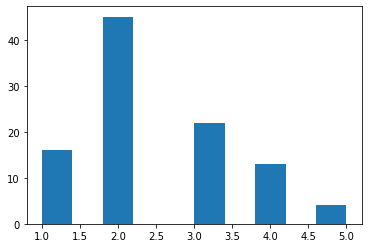

In [245]:
import matplotlib.pyplot as plt
plt.hist(left_count)

(array([ 1., 28.,  0., 33.,  0., 23., 13.,  0.,  1.,  1.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

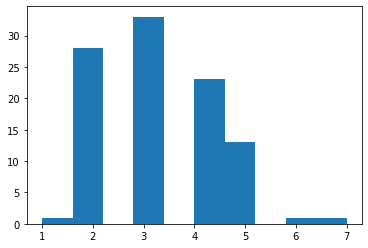

In [246]:
plt.hist(right_count)

In [151]:
# statistic of cskg_hard
lefts_=[]
rights_=[]
totals_=[]
for line in lines:
    subject_=line[1]
    rel_=line[2]
    object_=line[3]
    
    if subject_:
        lefts_.append(1)
    else:
        lefts_.append(0)
        
    if object_:
        rights_.append(1)
    else:
        rights_.append(0)
        
    if subject_ and object_:
        totals_.append(1)
    else:
        totals_.append(0)

In [152]:
print("Number of annoted subject: ",sum(lefts_))
print("Number of annoted object: ",sum(rights_))
print("Number of annoted edge: ",sum(totals_))

Number of annoted subject:  58
Number of annoted object:  53
Number of annoted edge:  49


## Sentence embedding for WordNet

In [117]:
model=SentenceTransformer("stsb-roberta-large")

In [118]:
synsets_name=[]
sents=[]

for label in wn.all_synsets():
    synsets_name.append(label.name())
    sents.append(label.definition())
    
sentence_embeddings = model.encode(sents)

In [119]:
# store to disk
with open(embed_cskg_hard,"w") as f:
    for label,sent in zip(synsets_name,sentence_embeddings):
        f.write(label)
        f.write(": ")
        f.write(",".join([str(_) for _ in sent])+"\n")

# example
sentence_embeddings[0]

array([-0.3253834 ,  0.21606368, -0.8423682 , ...,  0.51846933,
       -2.1251714 ,  0.7680165 ], dtype=float32)

In [120]:
d=len(sentence_embeddings[0])
index = faiss.IndexFlatL2(d)
index.add(sentence_embeddings)

#write to disk
faiss.write_index(index, faiss_cskg_hard)

In [121]:
# have a test
embed=model.encode(wn.synset("good.a.1").definition())

D, I = index.search(np.array([embed]), 1)
synsets_name[I[0][0]]

'good.a.01'

In [122]:
invert_synsets_name=dict()
idx=0
for label in synsets_name:
    invert_synsets_name[label]=idx
    idx+=1

In [123]:
wn.synset("good.a.1").name()

'good.a.01'

In [124]:
invert_synsets_name["good.a.01"]

6162

## Make Prediction

In [153]:
# filter the valide line
valid_lines=[]
for line in lines:
    subject_=line[1]
    rel_=line[2]
    object_=line[3]
    
    if subject_ and object_:
        valid_lines.append(line)
    else:
        pass

In [154]:
# make prediction
node_labels=[]
for line in valid_lines:
    subject_label=line[4]
    object_label=line[5]
    
    node_labels.append(subject_label)
    node_labels.append(object_label)
    
node_embed=model.encode(node_labels)

In [251]:
# make prediction
k=5000
D, I = index.search(np.array(node_embed), k)

In [252]:
# check accuracy
truth_idx=[]
for line in valid_lines:
    subject_= wn.synset(line[1].split(":")[1]).name()
    object_= wn.synset(line[3].split(":")[1]).name()
    truth_idx.append(invert_synsets_name[subject_])
    truth_idx.append(invert_synsets_name[object_])

sub_accuracy=[]
obj_accuracy=[]
for i in range(len(truth_idx)):
    predict_idxs=I[i]
    truth=truth_idx[i]
    if truth in predict_idxs:
        if i%2==0:
            sub_accuracy.append(1)
        else:
            obj_accuracy.append(1)
    else:
        if i%2==0:
            sub_accuracy.append(0)
        else:
            obj_accuracy.append(0)

In [253]:
sum(sub_accuracy)

30

In [254]:
sum(obj_accuracy)

42

In [241]:
D, I = index.search(np.array([model.encode("australian police")]), 10)

for i in I[0]:
    print(synsets_name[i])
    print(wn.synset(synsets_name[i]).definition())
    print()

adelaide.n.01
the state capital of South Australia

south_australia.n.01
a state in south central Australia

tall_yellow-eye.n.01
of Australia

chrysophrys.n.01
Australian snapper

new_south_wales.n.01
an Australian state in southeastern Australia

eyre_peninsula.n.01
a peninsula of southern Australia

jointed_rush.n.01
rush of Australia

canberra.n.01
the capital of Australia; located in southeastern Australia

australian.n.01
a native or inhabitant of Australia

victoria.n.06
a state in southeastern Australia



In [242]:
D, I = index.search(np.array([model.encode("police")]), 10)

for i in I[0]:
    print(synsets_name[i])
    print(wn.synset(synsets_name[i]).definition())
    print()

police.n.01
the force of policemen and officers

panda_car.n.01
a police cruiser

lieutenant.n.02
an officer in a police force

policeman.n.01
a member of a police force

captain.n.03
a policeman in charge of a precinct

police_precinct.n.01
a precinct in which law enforcement is the responsibility of particular police force

inspector.n.01
a high ranking police officer

flatfoot.n.01
a policeman who patrols a given region

detective.n.01
a police officer who investigates crimes

lawman.n.01
an officer of the law

